# Log Returns

_____

#### Book says: 

> **If returns are normally distributed, then compound returns are *not* normally distributed.**

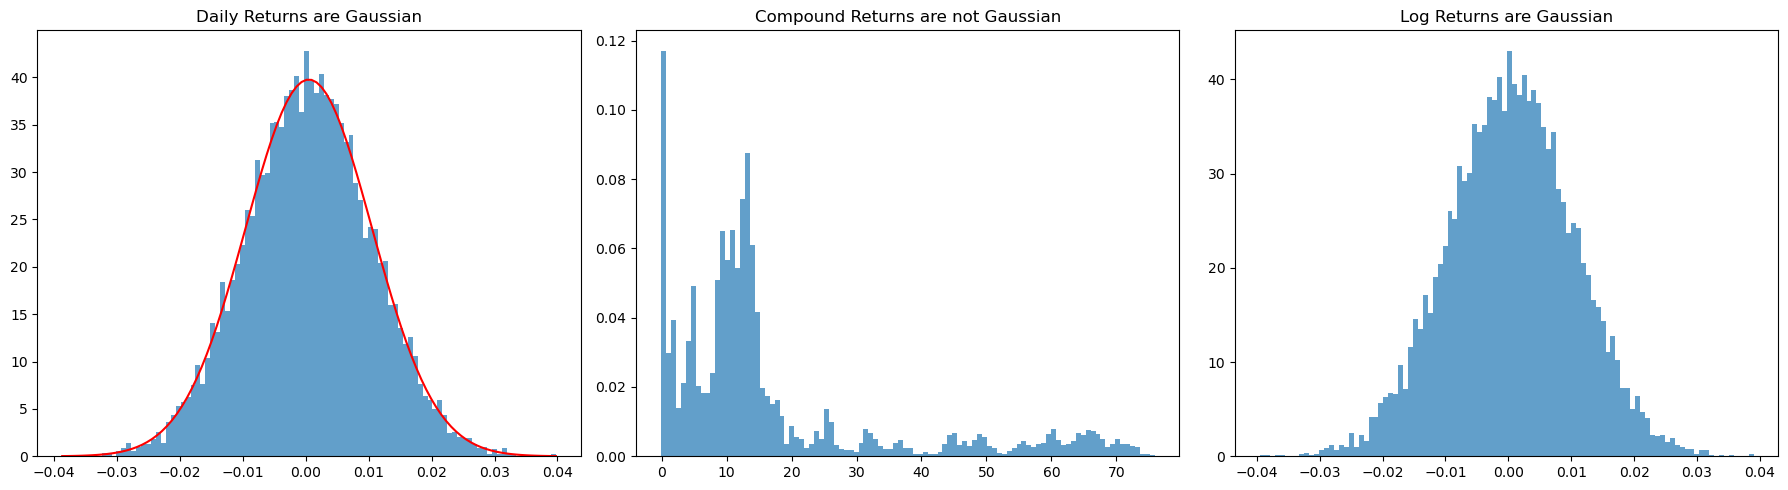

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

np.random.seed(42)
n_days = 10000
mu = 0.0005
sigma = 0.01

simple_returns = np.random.normal(mu, sigma, n_days)

# Cumulative product (simulate a price series)
prices = np.cumprod(1 + simple_returns)

# Compound returns (total return from starting point)
compound_returns = prices / prices[0] - 1

# Log returns
log_returns = np.log(1 + simple_returns)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Simple returns
axs[0].hist(simple_returns, bins=100, density=True, alpha=0.7)
x = np.linspace(simple_returns.min(), simple_returns.max(), 100)
axs[0].plot(x, norm.pdf(x, np.mean(simple_returns), np.std(simple_returns)), 'r')
axs[0].set_title('Daily Returns are Gaussian')

# Compound returns
axs[1].hist(compound_returns, bins=100, density=True, alpha=0.7)
axs[1].set_title('Compound Returns are not Gaussian')

# Log returns
axs[2].hist(log_returns, bins=100, density=True, alpha=0.7)
axs[2].set_title('Log Returns are Gaussian')

plt.tight_layout()
plt.show()

#### Book says: 

> **Sum of log returns is approximately equal to the actual compounded return. This approximation is more accurate for:**
> - Returns that are "sufficiently small"
> - Shorter timeframes (daily or lower)

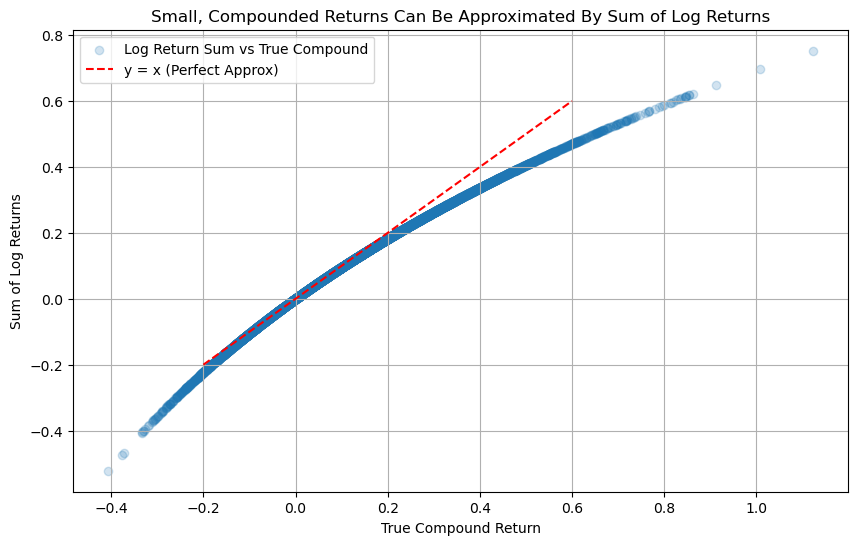

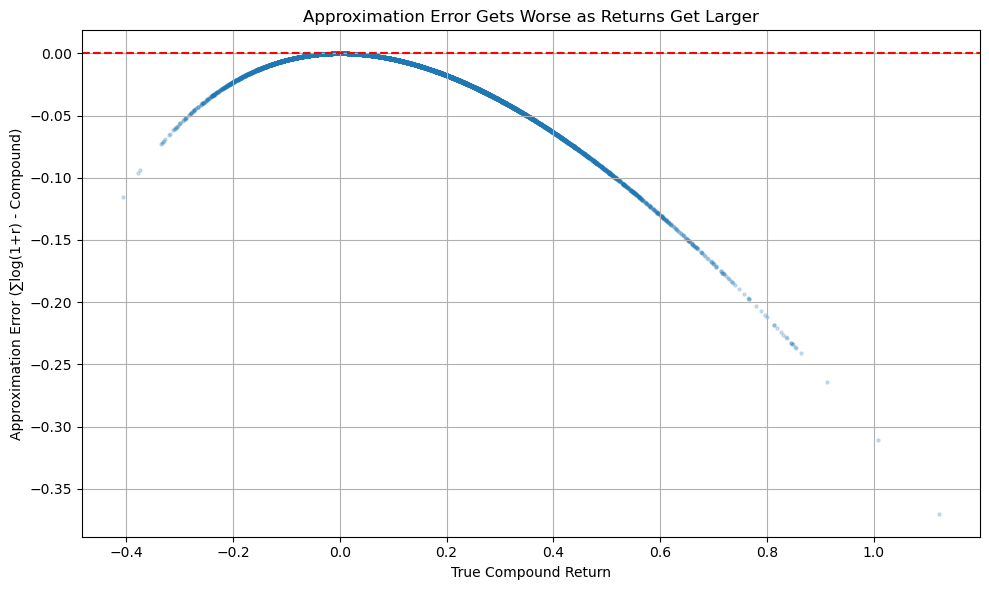

In [5]:
n_days = 252
n_trials = 10000

mu = 0.0005
sigma = 0.01

simple_returns = np.random.normal(mu, sigma, (n_trials, n_days))

log_returns = np.log(1 + simple_returns)

# spanish r tilda - this is the approximation
log_return_sums = np.sum(log_returns, axis=1)

# log the log returns to get the approximation
approx_compound_returns = np.exp(log_return_sums) - 1

# True compound return from cumulative product
true_compound_returns = np.prod(1 + simple_returns, axis=1) - 1

# Plot comparison
plt.figure(figsize=(10, 6))
plt.scatter(true_compound_returns, log_return_sums, alpha=0.2, label='Log Return Sum vs True Compound')
plt.plot([-0.2, 0.6], [-0.2, 0.6], 'r--', label='y = x (Perfect Approx)')
plt.xlabel('True Compound Return')
plt.ylabel('Sum of Log Returns')
plt.title('Small, Compounded Returns Can Be Approximated By Sum of Log Returns')
plt.legend()
plt.grid(True)
plt.show()

# Approximation error (linearizing exp(x) - 1 ≈ x)
approx_errors = log_return_sums - true_compound_returns

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(true_compound_returns, approx_errors, alpha=0.2, s=5)
plt.axhline(0, color='r', linestyle='--')
plt.title('Approximation Error Gets Worse as Returns Get Larger')
plt.xlabel('True Compound Return')
plt.ylabel('Approximation Error (∑log(1+r) - Compound)')
plt.grid(True)
plt.tight_layout()
plt.show()

  Interval  Compound Return  Sum of Log Returns  Abs Approximation Error  \
0     5min         0.002300            0.002298                 0.000003   
1    30min        -0.056142           -0.057780                 0.001638   
2    1hour        -0.080558           -0.083988                 0.003430   
3    4hour        -0.110182           -0.116738                 0.006556   

   Days in Interval  
0                11  
1                29  
2                88  
3               179  


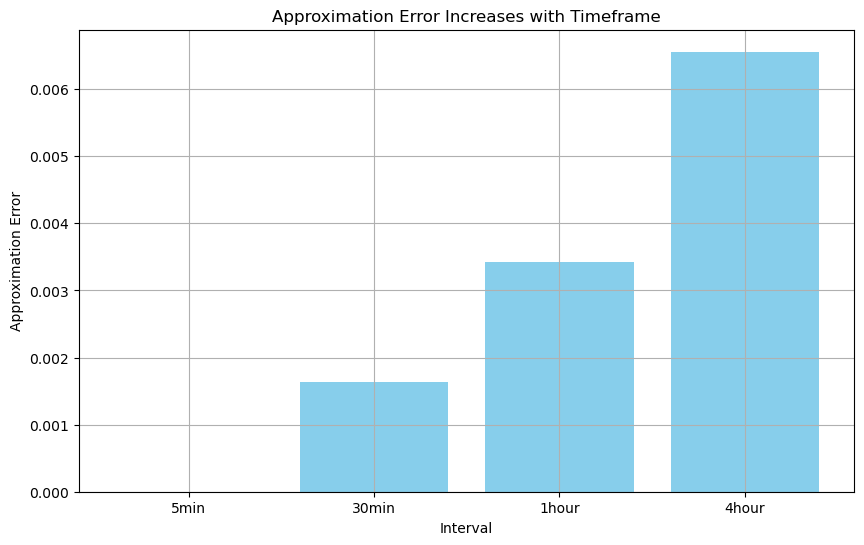

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import os
from dotenv import load_dotenv

load_dotenv()

API_KEY = os.getenv('FMP_API_KEY')
symbol = 'AAPL'
intervals = ['5min', '30min', '1hour', '4hour']

# Function to fetch intraday data
def fetch_intraday_data(symbol, interval, api_key):
    url = f'https://financialmodelingprep.com/api/v3/historical-chart/{interval}/{symbol}?apikey={api_key}'
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data)
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# calc approximation error between the log returns and the compound return
def compute_approximation_error(df):
    df['simple_return'] = df['close'].pct_change()
    df.dropna(inplace=True)
    df['log_return'] = np.log(1 + df['simple_return'])
    compound_return = (1 + df['simple_return']).prod() - 1
    log_return_sum = df['log_return'].sum()
    approximation_error = log_return_sum - compound_return
    return compound_return, log_return_sum, approximation_error

def get_days_in_interval(df):
    return (df['date'].iloc[-1] - df['date'].iloc[0]).days

results = []

for interval in intervals:
    df = fetch_intraday_data(symbol, interval, API_KEY)
    compound_return, log_return_sum, error = compute_approximation_error(df)
    days = get_days_in_interval(df)
    results.append({
        'Interval': interval,
        'Compound Return': compound_return,
        'Sum of Log Returns': log_return_sum,
        'Abs Approximation Error': abs(error),
        'Days in Interval': days
    })

results_df = pd.DataFrame(results)

print(results_df)

plt.figure(figsize=(10, 6))
plt.bar(results_df['Interval'], results_df['Abs Approximation Error'], color='skyblue')
plt.title('Approximation Error Increases with Timeframe')
plt.xlabel('Interval')
plt.ylabel('Approximation Error')
plt.grid(True)
plt.show()

  Symbol Interval  Compound Return  Sum of Log Returns  \
0   ARKK     5min         0.085319            0.081874   
1   ARKK    30min        -0.009707           -0.009754   
2   ARKK    1hour        -0.167481           -0.183300   
3   ARKK    4hour         0.052350            0.051025   
4   VTIP     5min         0.006539            0.006518   
5   VTIP    30min         0.006742            0.006719   
6   VTIP    1hour         0.026233            0.025895   
7   VTIP    4hour         0.027304            0.026938   

   Abs Approximation Error  Days in Interval  
0                 0.003445                11  
1                 0.000047                29  
2                 0.015818                88  
3                 0.001324               179  
4                 0.000021                11  
5                 0.000023                29  
6                 0.000338                88  
7                 0.000366               179  


/Users/MilesChild/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/MilesChild/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/MilesChild/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/MilesChild/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

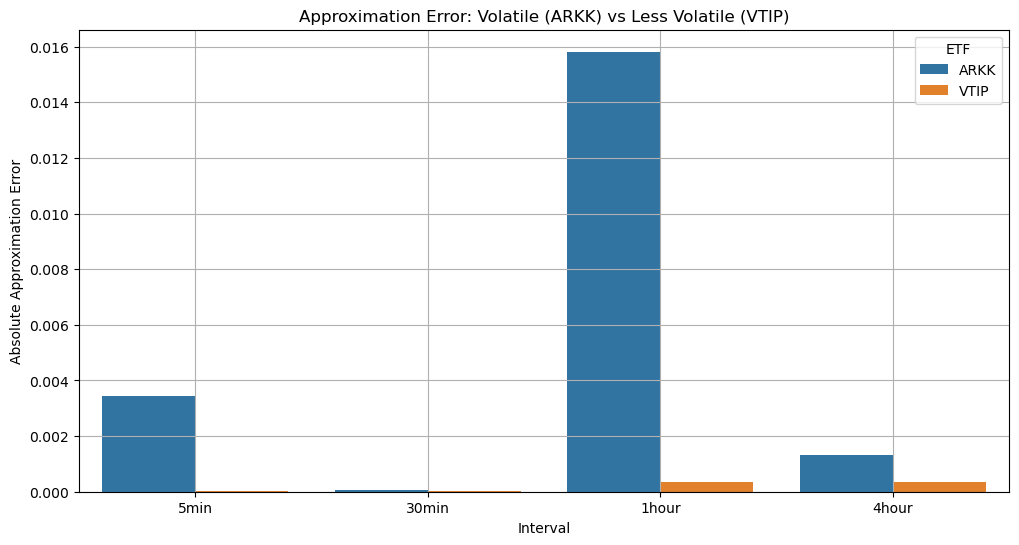

In [21]:
symbols = ['ARKK', 'VTIP']  # cathy wood vs average country club member

results = []

for symbol in symbols:
    for interval in intervals:
        df = fetch_intraday_data(symbol, interval, API_KEY)
        if df.empty or len(df) < 2:
            continue
        compound_return, log_return_sum, error = compute_approximation_error(df)
        days = get_days_in_interval(df)
        results.append({
            'Symbol': symbol,
            'Interval': interval,
            'Compound Return': compound_return,
            'Sum of Log Returns': log_return_sum,
            'Abs Approximation Error': abs(error),
            'Days in Interval': days
        })

results_df = pd.DataFrame(results)

# Print results
print(results_df)

# Plot: Volatile vs Non-Volatile ETFs
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x='Interval', y='Abs Approximation Error', hue='Symbol')
plt.title('Approximation Error: Volatile (ARKK) vs Less Volatile (VTIP)')
plt.xlabel('Interval')
plt.ylabel('Absolute Approximation Error')
plt.grid(True)
plt.legend(title='ETF')
plt.show()